<a href="https://colab.research.google.com/github/svondracek0/dtse-applied-ts/blob/master/airline_analysis/airline_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Time Series Analysis by DTSE AIS

In this course, you will be introduced to the concept of time series analysis and forecasting. You will learn how to use time series data to forecast future values using statistical models.
You will also learn how to evaluate the performance of the models and select an optimal model for forecasting. To do so, we will be using some of the standard libraries in Python such as pandas, numpy, matplotlib, sktime and statsmodels.

## 1 Time Series and its properties
In this section, we will be using the airline dataset which contains an information on total number of airline passengers over the period spanning from 1949 to 1960.

In [ ]:
!pip install pmdarima
!pip install sktime==0.32

In [ ]:
# this code cell is used to import the necessary libraries (it is a good practice to do this in the beginning of the notebook)
from sktime.datasets import load_airline
from pmdarima.datasets import load_lynx
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sktime.forecasting.arima import ARIMA
from statsmodels.tsa.statespace.tools import diff
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### 1.1 Loading and presenting the dataset
It is important to load the dataset and present it in a way that we can understand the data and its properties. Time series is usually visualized using line plots, although one can use more sophisticated methods over aggregated/disaggregated data, such as
candle plots etc.

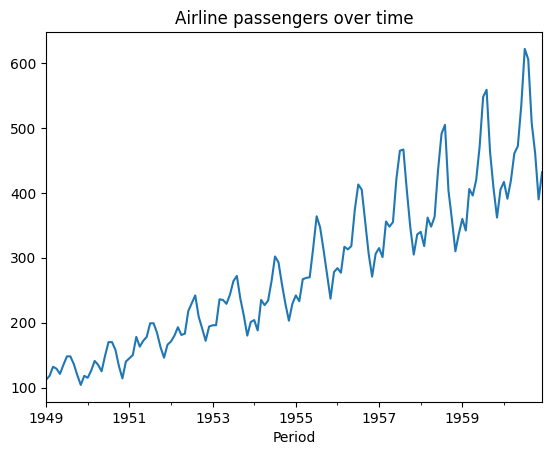

In [ ]:
airline = load_airline()
airline.index = airline.index.to_timestamp()  # convert the period index to timestamp
fig = airline.plot(title='Airline passengers over time')
plt.show()

In [ ]:
# length of our time series
print(airline.shape)

(144,)


In [ ]:
# periodicity of the time series
airline.index[1] - airline.index[0]

Timedelta('31 days 00:00:00')

In [ ]:
144 / 12

12.0

So what are the characteristics that distinguish time series from other form of dataset?
- Time series data is ordered, meaning that the order of the data points is important
- points are usually equally spaced in time (usual algorithms need this property which can be ensured during the preprocessing)
- time series can be both univariate and multivariate, today we will be focusing on univariate time series
- time series has certain properties that we will tackle in the upcoming section

### 1.2 Basic time series properties
Time series can have various properties of which today we will be focusing on the following:
- Trend: a long-term increase or decrease in the data
- Seasonality: a pattern that repeats at regular intervals (e.g. daily, weekly, monthly, yearly)
- TODO: Could you think of some examples for each of the categories?



Solution:
- daily seasonality: the number of people visiting a park
- weekly seasonality: the number of people visiting a church
- monthly seasonality: the number of people going to Postal office (e.g. picking up their rents)
- yearly seasonality: toy sales

In [ ]:
airline_decomposed = seasonal_decompose(airline, period=12)

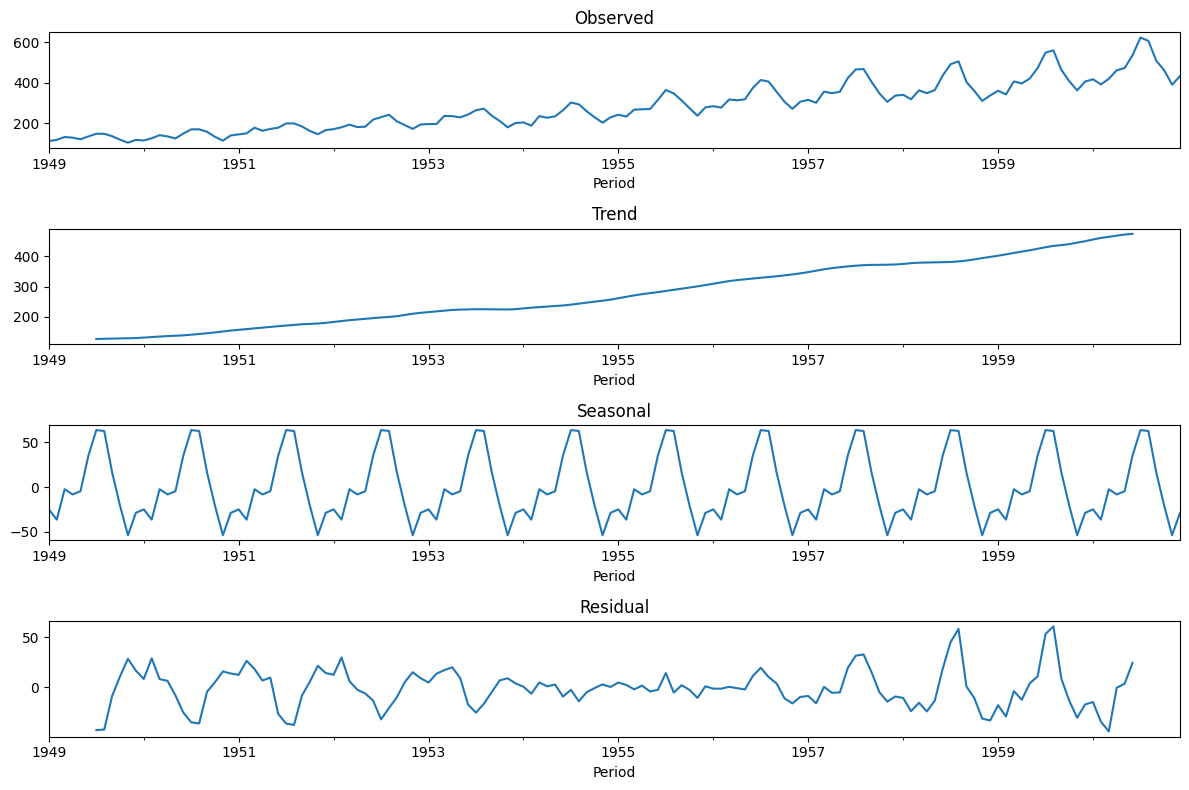

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(12, 8))

airline_decomposed.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Observed')
airline_decomposed.trend.plot(ax=axes[1], legend=False)
axes[1].set_title('Trend')
airline_decomposed.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_title('Seasonal')
airline_decomposed.resid.plot(ax=axes[3], legend=False)
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

### 1.3 Advanced time series properties

Apart from the basic properties, time series can have more advanced properties such as:
- Autocorrelation: the correlation of a time series with a lagged version of itself
- Partial autocorrelation: the correlation of a time series with a lagged version of itself after removing the effect of the intermediate lags
- Stationarity: a property of time series where the mean, variance and autocorrelation structure do not change over time
- Hetereoskedasticity: a property of time series where the variance of the time series changes over time

#### 1.3.1 Autocorrelation
Autocorrelation is a measure of how a time series is correlated with a lagged version of itself. It is a useful property to
understand the underlying structure of the time series and can be used to identify the order of the autoregressive model.

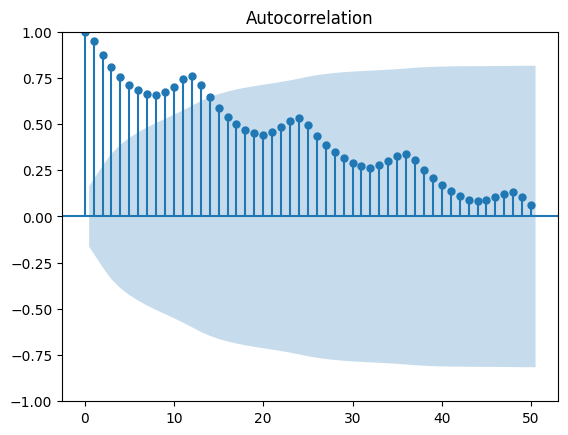

In [ ]:
plot_acf(airline, lags=50)
plt.show()

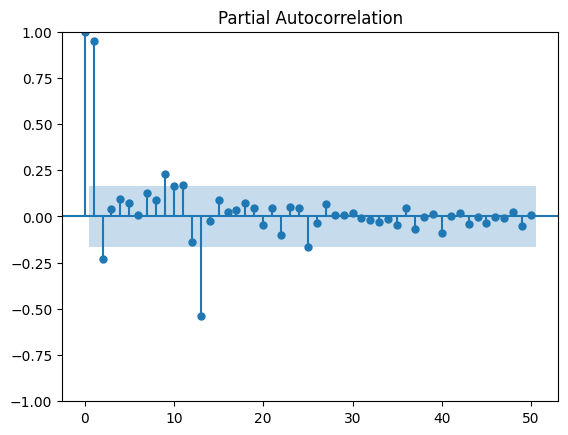

In [ ]:
plot_pacf(airline, lags=50)
plt.show()

### 1.3.2 Stationarity
Stationarity is a property of time series where the mean, variance and autocorrelation structure do not change over time.
It is an important property for time series analysis as many of the time series models assume that the time series is stationary.
It can be tested using the Augmented Dickey-Fuller test.

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(airline)
print(adf_result[1])

0.991880243437641


The p-value of the Augmented Dickey-Fuller test is 0.99 which is greater than 0.05. This means that we fail to reject the null hypothesis that the time series is non-stationary. We can therefore assume that the time series is non-stationary and we might need to do some transformation before the modelling. We will come to this when assessing the quality of our models

### 1.3.3 Hetereoskedasticity
Hetereoskedasticity is a property of time series where the variance of the time series changes over time. It is an important property to consider when modelling time series data as it can affect the performance of the model. It can be tested using the ARCH test.

In [ ]:
from statsmodels.stats.diagnostic import het_arch
print(het_arch(airline)[1])

2.961233760503082e-22


The very low p-value of the ARCH test indicates that the time series is heteroskedastic. This means that the variance of the time series changes over time and we might need to do some transformation before the modelling.

### 1.4 Transforming the time series
In this section, we will transform the series to make it at least stationary. To do so, we will use seasonal differencing.

In [ ]:
diff_airline = airline.diff().dropna()

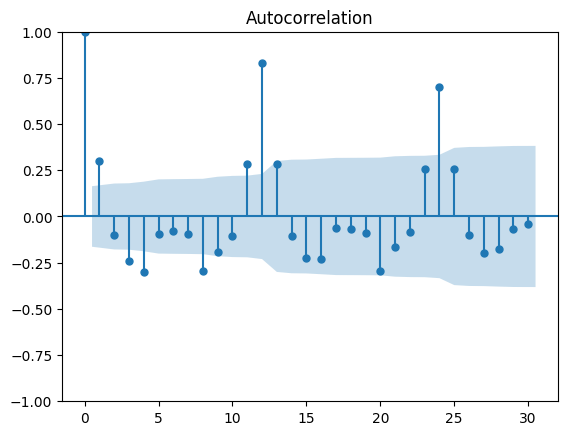

In [ ]:
plot_acf(diff_airline, lags=30)
plt.show()

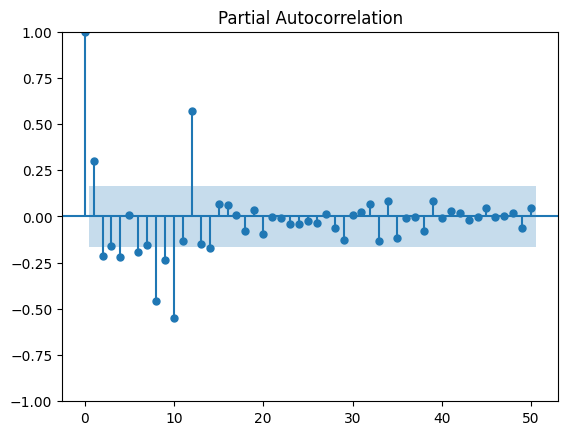

In [ ]:
plot_pacf(diff_airline, lags=50)
plt.show()

In [ ]:
diff_decomposed = seasonal_decompose(diff_airline.dropna(), period=12)

Text(0.5, 1.0, 'Residual')

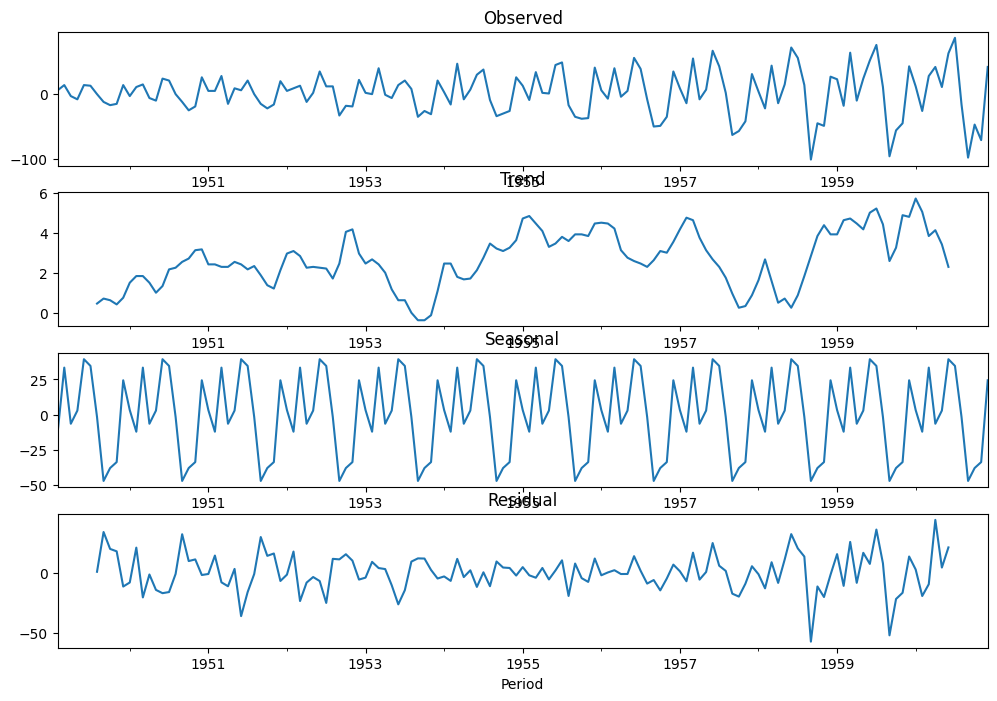

In [ ]:
# make the x axis legend only at the lowest plot
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
diff_decomposed.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Observed')
diff_decomposed.trend.plot(ax=axes[1], legend=False)
axes[1].set_title('Trend')
diff_decomposed.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_title('Seasonal')
diff_decomposed.resid.plot(ax=axes[3], legend=False)
axes[3].set_title('Residual')

## 2 Selecting the forecasting strategy

In this section, we will try a few forecasting approaches and evaluate which is the best one

### 2.1 Model training and cross validation

To select a model, we must select a proper strategy for model training and cross validation. The process of training stands for selecting the most appropriate set of model parameters by letting the model see new subsets of data. The process of cross validation stands for evaluating the model performance on the unseen data. In time series, we must be careful to not leak the information from the future into the past. To do so, we will be using the following strategy:

- Train the model on the first 80% of the data
- Evaluate the model on the last 20% of the data


In [ ]:
train_size = int(0.8 * len(airline))
train_index = airline.index[:train_size]
test_index = airline.index[train_size:]

In [ ]:
airline_train = airline.loc[train_index]
airline_test = airline.loc[test_index]
print(f"Training data size: {len(airline_train)}, Test data size: {len(airline_test)}")

Training data size: 115, Test data size: 29


In [ ]:
airline_train.index[-1] < airline_test.index[0]

True

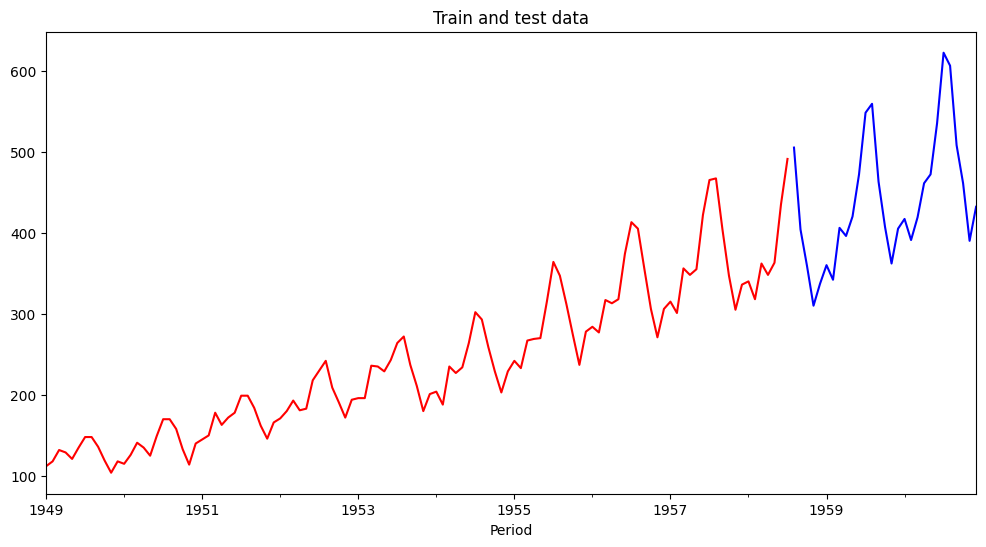

In [ ]:
# let's plot the train and test data into the same plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
airline_train.plot(ax=ax, color="red", title="Train and test data")
airline_test.plot(ax=ax, color="blue")
plt.show()

### 2.2 Linear Regression

Anyone who's ever taken part in an introductory course to machine learning, must've come across a linear regression. This method explains the target variable using a linear combination of the features, choosing such fit that minimizes the sum of the squares of the residuals (error). In our case, we will be using time index as a feature and number of passengers as target variable. In the next cell, we introduce the time variable which will be used as a covariate. Then we fit a basic linear regression model and predict


In [ ]:
airline_regression = pd.DataFrame(airline).assign(time=[i + 1 for i in range(len(airline))])
airline_regression

,Number of airline passengers,time
Period,,
1949-01-01,112.0,1
1949-02-01,118.0,2
1949-03-01,132.0,3
1949-04-01,129.0,4
1949-05-01,121.0,5
...,...,...
1960-08-01,606.0,140
1960-09-01,508.0,141
1960-10-01,461.0,142


In [ ]:
model = LinearRegression()
model.fit(X=airline_regression.loc[train_index, ['time']],
          y=airline_regression.loc[train_index,'Number of airline passengers'])

LinearRegression()

In [ ]:
pred_regression = pd.DataFrame({'Number of airline passengers': model.predict(airline_regression.loc[test_index, ['time']]),
                       'Period': test_index}).set_index("Period")

In [ ]:
full_regression = pd.concat([pd.DataFrame(airline).assign(data_type="actual"), pd.DataFrame(pred_regression).assign(data_type="regression_forecast")])

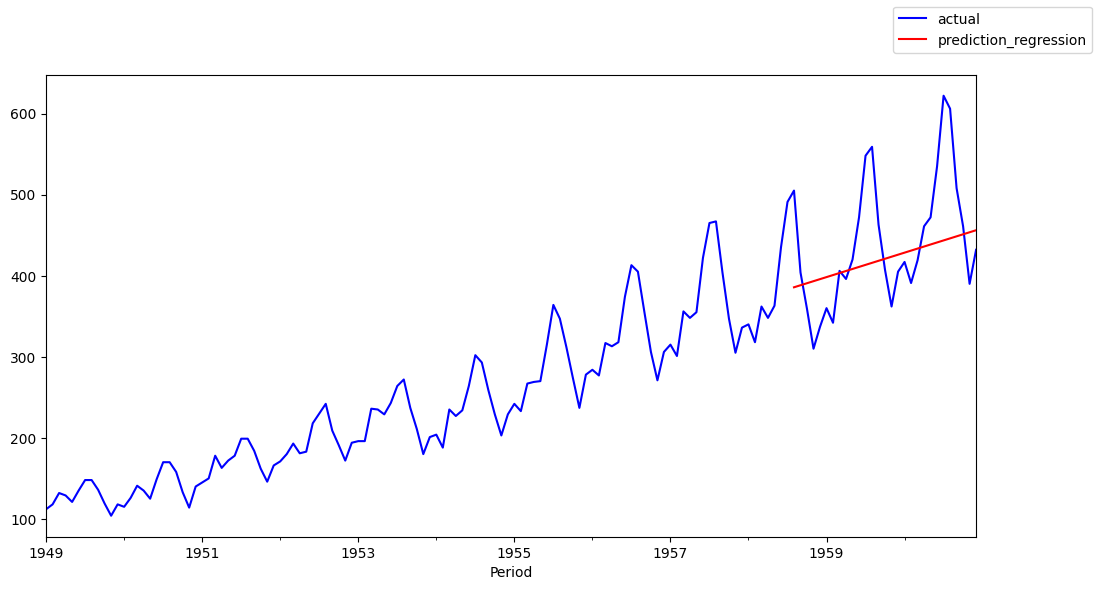

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
full_regression.query('data_type == "actual"')['Number of airline passengers'].plot(ax=ax, color='blue', label='actual')
full_regression.query('data_type == "regression_forecast"')['Number of airline passengers'].plot(ax=ax, color='red', label='prediction_regression')
fig.legend()
plt.show()

### 2.3 Predict using trend and seasonality

We've seen that linear regression fails to capture the seasonal patterns of our data and we might need to use a more sophisticated model. In this section, we will use the trend and seasonality to predict the future values of the time series.



In [ ]:
df_trend = pd.concat([airline_decomposed.trend, airline_decomposed.seasonal], axis=1).assign(
    time=[i + 1 for i in range(len(airline_decomposed.trend))])


In [ ]:
model = LinearRegression()
y = df_trend.loc[train_index]['trend'].dropna()
X = df_trend.loc[y.index, ['time']].dropna()
model.fit(X=X, y=y)

LinearRegression()

In [ ]:
y_pred = model.predict(df_trend.loc[test_index, ['time']])  + df_trend.loc[test_index, 'seasonal']
y_pred

,seasonal
Period,
1958-08-01,449.914402
1958-09-01,406.176096
1958-10-01,371.577941
1958-11-01,341.191908
1958-12-01,368.730117
1959-01-01,375.166053
1959-02-01,366.291383
1959-03-01,402.803077
1959-04-01,399.572346


In [ ]:
pred_trend_seas = pd.DataFrame(y_pred).rename(columns={"seasonal": "Number of airline passengers"}).assign(data_type="trend_seas_forecast")

In [ ]:
df_complete = pd.concat([pd.DataFrame(airline).assign(data_type="actual"), pred_trend_seas])

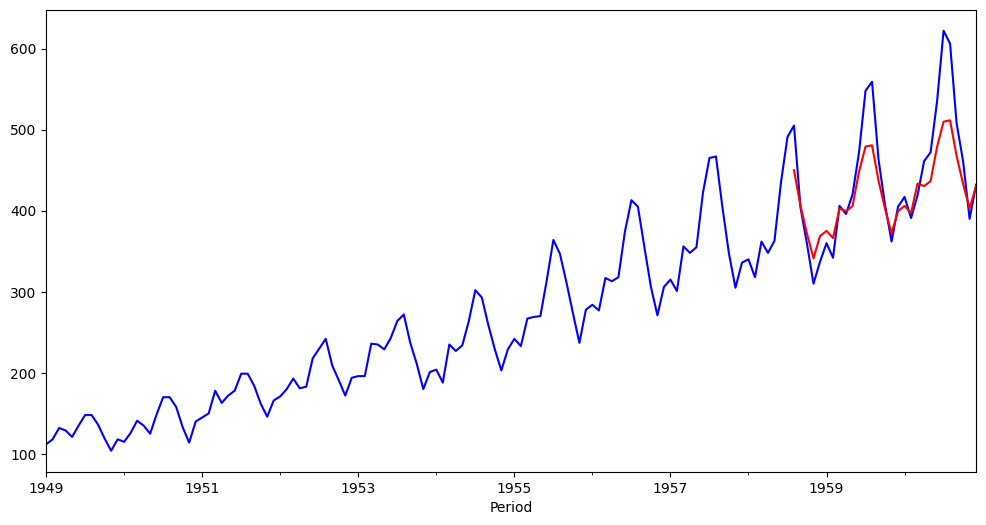

In [ ]:
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_complete.query('data_type == "actual"')['Number of airline passengers'].plot(ax=ax, color='blue', label='actual')
df_complete.query('data_type == "trend_seas_forecast"')['Number of airline passengers'].plot(ax=ax, color='red', label='pred_trend')
plt.show()

### 3.4 Prediction using ARMA model

In [ ]:
pd.Series(airline.loc[train_index].reset_index(drop=True))

,Number of airline passengers
0,112.0
1,118.0
2,132.0
3,129.0
4,121.0
...,...
110,362.0
111,348.0
112,363.0
113,435.0


In [ ]:
import pmdarima
forecaster = ARIMA(
    order=(1, 1, 0),
    seasonal_order=(0, 1, 0, 12),
    suppress_warnings=True)

forecaster.fit(airline.loc[train_index].reset_index(drop=True))
y_pred = forecaster.predict(fh=[i for i in range(1, len(test_index) + 1)])

In [ ]:
pred_arima = pd.DataFrame(y_pred).set_index(test_index).assign(data_type="pred_arima")

In [ ]:
df_arima_full = pd.concat([pd.DataFrame(airline).assign(data_type="actual"), pred_arima])

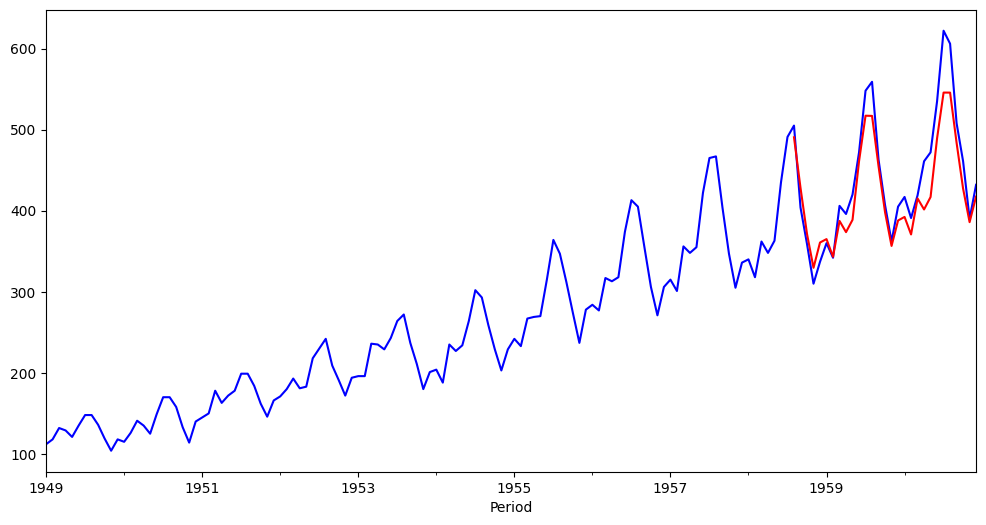

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_arima_full.query('data_type == "actual"')['Number of airline passengers'].plot(ax=ax, color='blue', label='actual')
df_arima_full.query('data_type == "pred_arima"')['Number of airline passengers'].plot(ax=ax, color='red', label='pred_arima')
plt.show()

Now that we've estimated 3 models, we can plot the results in a single plot:

In [ ]:
df_preds_all = pd.DataFrame(index=test_index)
df_preds_all = df_preds_all.assign(pred_arima=pred_arima['Number of airline passengers'],
                    pred_trend=pred_trend_seas['Number of airline passengers'],
                    pred_regression=pred_regression['Number of airline passengers']).reset_index().melt(id_vars="Period",
                                                                                                var_name="data_type",
                                                                                                value_name="Number of airline passengers").set_index("Period")
df_preds_all

,data_type,Number of airline passengers
Period,,
1958-08-01,pred_arima,490.572611
1958-09-01,pred_arima,428.306359
1958-10-01,pred_arima,371.392376
1958-11-01,pred_arima,329.611116
1958-12-01,pred_arima,360.802660
...,...,...
1960-08-01,pred_regression,446.060743
1960-09-01,pred_regression,448.574315
1960-10-01,pred_regression,451.087888


In [ ]:
df_all = pd.concat([pd.DataFrame(airline).assign(data_type="actuals"),
                    df_preds_all], axis=0).reset_index().sort_values(['Period', 'data_type']).set_index("Period")

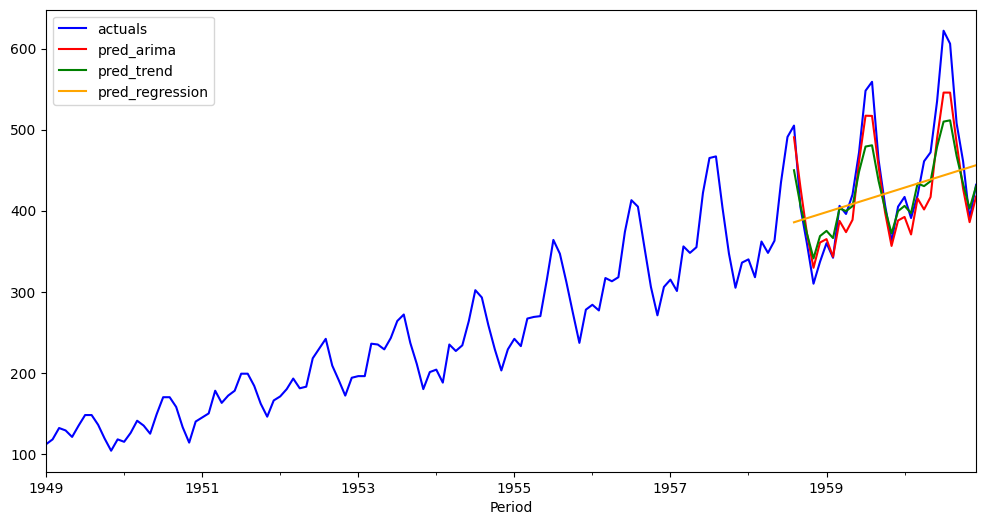

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_all.query('data_type == "actuals"')['Number of airline passengers'].plot(ax=ax, color='blue', label='actuals')
df_all.query('data_type == "pred_arima"')['Number of airline passengers'].plot(ax=ax, color='red', label='pred_arima')
df_all.query('data_type == "pred_trend"')['Number of airline passengers'].plot(ax=ax, color='green', label='pred_trend')
df_all.query('data_type == "pred_regression"')['Number of airline passengers'].plot(ax=ax, color='orange', label='pred_regression')
ax.legend()
plt.show()

## 3 Evaluating the models

In the previous section, we have estimated a few models, gradually improving the performance. However, when steering strategic decsisions, business side usually wants to have a single source of truth. To do so, we must evaluate the models and select the best one. The selection of model is usually based on some metric which compares the actual and predicted values. In time series, we usually use the following metrics:
- Mean Absolute Percentage Error (MAPE): the average of the absolute percentage errors
- Mean Squared Error (MSE): the average of the squared errors
- Root Mean Squared Error (RMSE): the square root of the average of the squared errors

It is always important to select the metric which is most relevant to the business problem. Could you provide some reasoning for metric selection behind following scenarios?
- Business needs to have accurate planning of the yearly budget
- Business is making decisions every month, adjusting the previous month expectation

In [ ]:
# Which model performs the best on average?
y_true = airline_test.loc[test_index]

y_arima = pred_arima.loc[test_index, 'Number of airline passengers']
y_trend = pred_trend_seas.loc[test_index, 'Number of airline passengers']
y_regression = pred_regression.loc[test_index, 'Number of airline passengers']

In [ ]:
 for y_pred, name in zip([y_arima, y_trend, y_regression], ['arima', 'trend', 'regression']):
    print(f"MAPE for {name}: {mean_absolute_percentage_error(y_true, y_pred)}")

MAPE for arima: 0.05313208286385156
MAPE for trend: 0.06102020954841454
MAPE for regression: 0.1207138013428198


How about aggregating the errors over the whole year and only then calculating the MAPE?

In [ ]:
# create a function which aggregates the errors over the year
def mape_yearly(y_true, y_pred):
    df_res_agg = pd.DataFrame(index=y_true.index)
    df_res_agg['true'] = y_true
    df_res_agg['pred'] = y_pred
    df_res_agg['year'] = df_res_agg.index.year

    df_res_agg = df_res_agg.groupby('year').sum()
    return mean_absolute_percentage_error(df_res_agg['true'], df_res_agg['pred'])

In [ ]:
 for y_pred, name in zip([y_arima, y_trend, y_regression], ['arima', 'trend', 'regression']):
    print(f"Yearly MAPE for {name}: {mape_yearly(y_true, y_pred)}")

Yearly MAPE for arima: 0.04834285541950495
Yearly MAPE for trend: 0.037029916762411526
Yearly MAPE for regression: 0.0430816864829086


# Machine Learning Approach to Time Series Forecasting

In this section, we will showcase a simple example of how to approach time series forecasting using a brute-force machine learning functionality. This approach is particularly useful when we need to compare multiple models, each with several parameters that can be **tuned** to achieve the best fit across different time series.

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Exponential Smoothing Forecast vs Actual values'}, ylabel='Number of airline passengers'>)

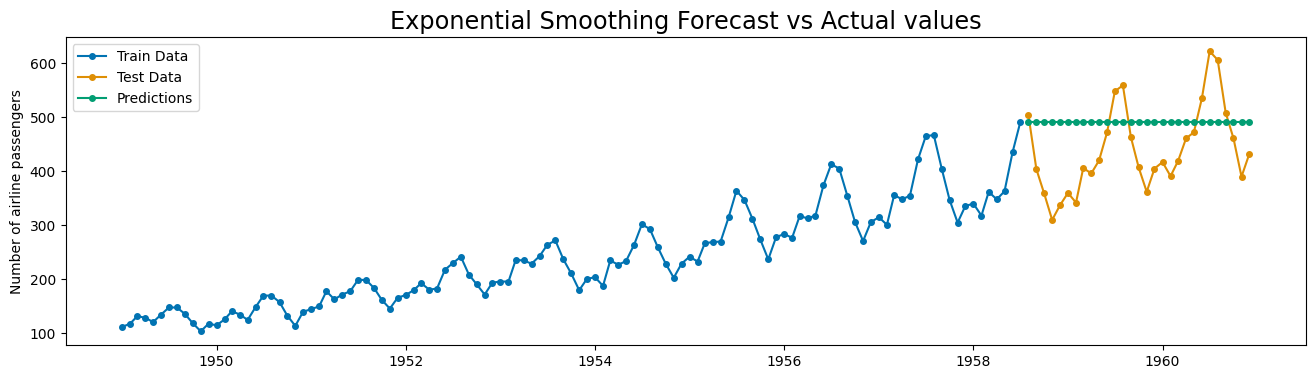

In [ ]:
# Convert the date index to PeriodIndex required by sktime
airline_train.index = pd.PeriodIndex(airline_train.index, freq="M")
airline_test.index = pd.PeriodIndex(airline_test.index, freq="M")

# Define forecasting horizon (how far ahead we want to predict)
fh = ForecastingHorizon(airline_test.index, is_relative=False)

# Initialize model
model = ExponentialSmoothing()

# Fit the model on the training data
model.fit(airline_train)

# Make predictions
airline_pred_es = model.predict(fh)

# Plot the predictions against the actual test set
plot_series(airline_train, airline_test, airline_pred_es, labels=["Train Data", "Test Data", "Predictions"], title="Exponential Smoothing Forecast vs Actual values")

#### Cross-Validation Strategies

We can evaluate models using different cross-validation (CV) strategies. Let’s explore expanding window and sliding window CV.

In [ ]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sktime.split import ExpandingWindowSplitter
from sktime.split import SlidingWindowSplitter

In [ ]:
def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows."""
    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = ((leg[:2]) for leg in ax.get_legend_handles_labels())
    ax.legend(handles, labels)

In [ ]:
def get_windows(y, cv):
    """Generate windows."""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows

In [ ]:
# Expanding window cross-validation
expanding_cv = ExpandingWindowSplitter(initial_window=24, step_length=12, fh=np.arange(1, 13))

n_splits = expanding_cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 7


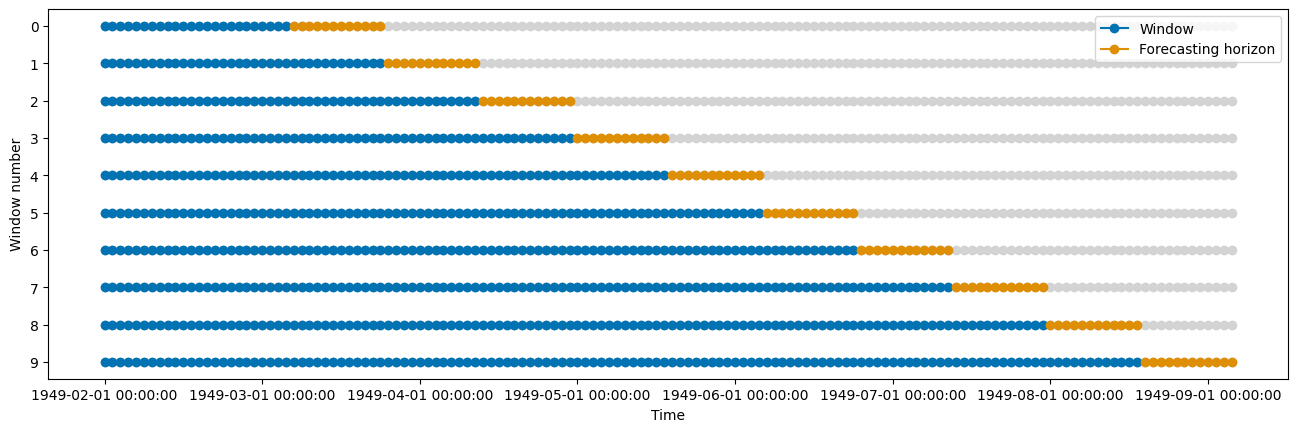

In [ ]:
train_windows, test_windows = get_windows(airline, expanding_cv)
plot_windows(airline, train_windows, test_windows)

In [ ]:
# Sliding window cross-validation
sliding_cv = SlidingWindowSplitter(window_length=24, step_length=12, fh=np.arange(1, 13))

n_splits = sliding_cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 7


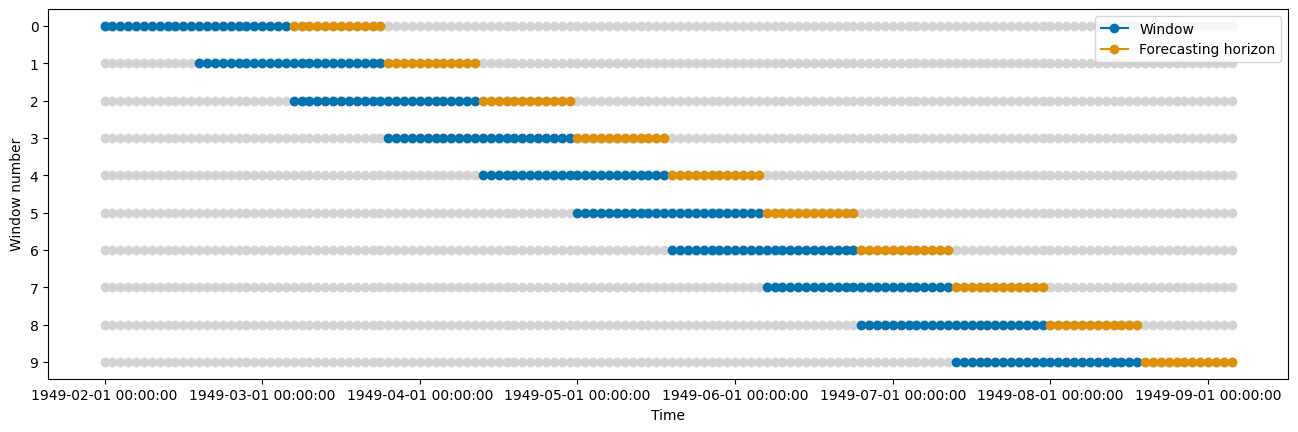

In [ ]:
train_windows, test_windows = get_windows(airline, sliding_cv)
plot_windows(airline, train_windows, test_windows)

#### Hyperparameter Tuning

We can perform backtesting to evaluate our model over multiple time periods using cross-validation.

In [ ]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanSquaredError

In [ ]:
# Define error metric
rmse = MeanSquaredError(square_root=True)

# Define parameter grid for tuning ExponentialSmoothing model defined earlier
param_grid = {'smoothing_level': [0.2, 0.5, 0.8]}

def train_and_plot(cv_strategy):
    # Set up grid search with cross-validation
    gscv = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv_strategy, scoring=rmse)

    # Fit the grid search
    gscv.fit(airline_train)

    # Get the best found parameters
    print(f"Performances on individual folds: {gscv.cv_results_}")
    print(f"Best params: {gscv.best_params_}")

    # Forecast using the best model
    airline_pred_es = gscv.predict(fh)

    # Plot the predictions against the actual test set
    plot_series(airline_train, airline_test, airline_pred_es, labels=["Train Data", "Test Data", "Predictions"], title=f"Backtesting with Cross-Validation ({cv_strategy})")
    return airline_pred_es

Let's first try using **ExpandingWindow**

Performances on individual folds:    mean_test_MeanSquaredError  mean_fit_time  mean_pred_time  \
0                   50.031183       0.010584        0.010218   
1                   56.662284       0.016552        0.011023   
2                   58.198497       0.007277        0.006613   

                     params  rank_test_MeanSquaredError  
0  {'smoothing_level': 0.2}                         1.0  
1  {'smoothing_level': 0.5}                         2.0  
2  {'smoothing_level': 0.8}                         3.0  
Best params: {'smoothing_level': 0.2}


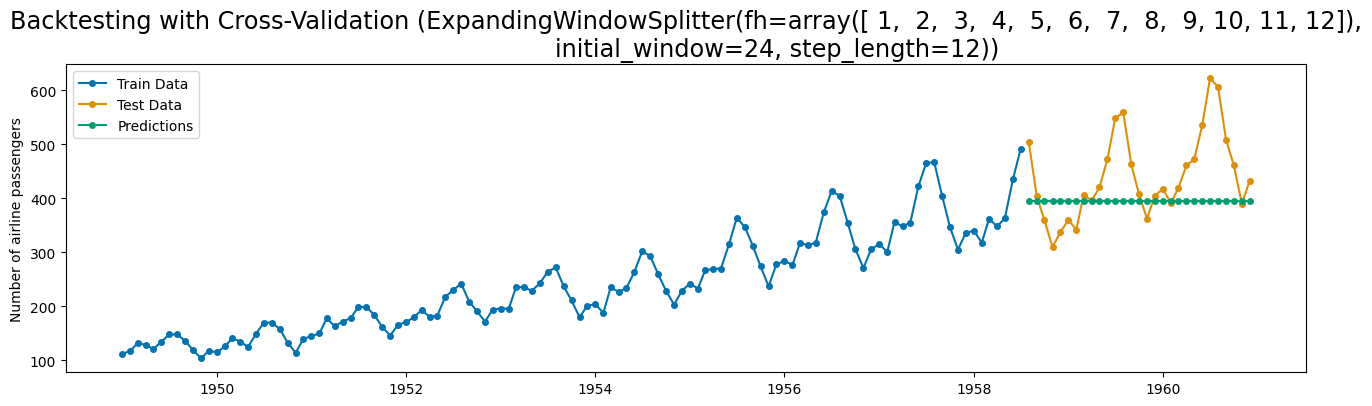

In [ ]:
airline_train_es = train_and_plot(expanding_cv)

And not with **SlidingWindow**

Performances on individual folds:    mean_test_MeanSquaredError  mean_fit_time  mean_pred_time  \
0                   49.967920       0.012442        0.010302   
1                   56.662284       0.010282        0.011128   
2                   58.198497       0.006765        0.005883   

                     params  rank_test_MeanSquaredError  
0  {'smoothing_level': 0.2}                         1.0  
1  {'smoothing_level': 0.5}                         2.0  
2  {'smoothing_level': 0.8}                         3.0  
Best params: {'smoothing_level': 0.2}


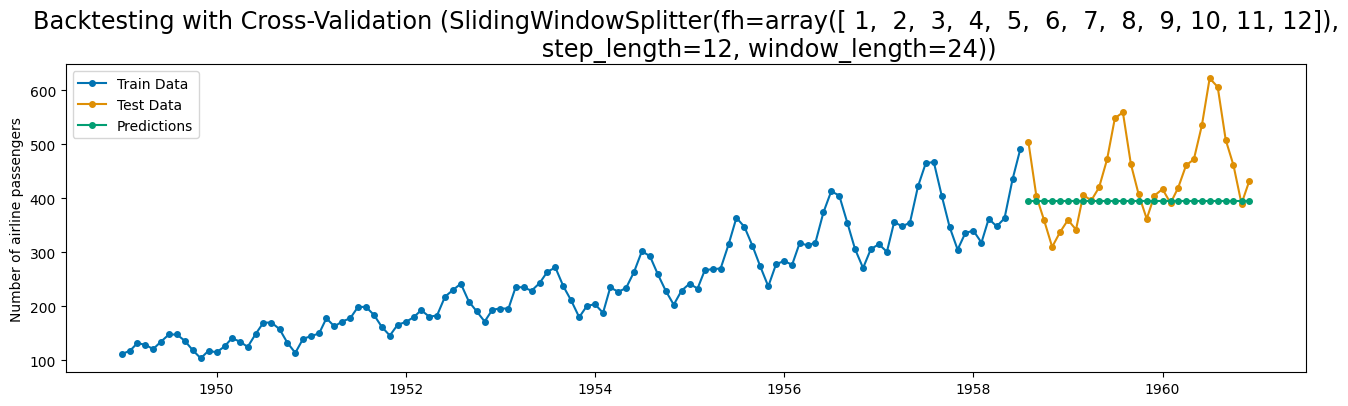

In [ ]:
airline_train_es = train_and_plot(sliding_cv)

####  Comparing Multiple Models

You can also compare different models (e.g., ARIMA, Exponential Smoothing, Random Forest) and their performance.

Let's first fit **ARIMA** model.

In [ ]:
from sktime.forecasting.arima import ARIMA
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

In [ ]:
# Initialize a new model (ARIMA)
arima_model = ARIMA()

# Define parameter grid and GSCV Forecaster
param_grid_arima = {'order': [(1, 0, 0), (1, 0, 1), (1, 1, 1), (2, 1, 1), (2, 1, 2)],
                    'seasonal_order': [(0, 1, 0, 12), (1, 1, 0, 12), (1, 1, 1, 12)]}

gscv_arima = ForecastingGridSearchCV(forecaster=arima_model, param_grid=param_grid_arima, cv=expanding_cv, scoring=rmse)

# Fit the grid search with ARIMA configuration on training data
gscv_arima.fit(airline_train)
print(f"Best parameters: {gscv_arima.best_params_}")

# Make predictions using ARIMA
airline_pred_arima = gscv_arima.predict(fh)

Best parameters: {'order': (2, 1, 1), 'seasonal_order': (1, 1, 0, 12)}


And now let's try **k-nearest neighbors** (ML and not statistical model)

In [ ]:
# Initialize a new model (KNN)
knn_regressor = make_reduction(KNeighborsRegressor(), strategy="recursive")

# Define parameter grid and GSCV Forecaster
param_grid_knn = {"estimator__n_neighbors": np.arange(1, 8)}

gscv_knn = ForecastingGridSearchCV(forecaster=knn_regressor, param_grid=param_grid_knn, cv=expanding_cv)

# Fit the grid search with KNN configuration on training data
gscv_knn.fit(airline_train)
print(f"Best parameters: {gscv_knn.best_params_}")

# Make predictions using KNN
airline_pred_knn = gscv_knn.predict(fh)

Best parameters: {'estimator__n_neighbors': 1}


(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Model Comparison: Exponential Smoothing vs ARIMA vs KNN'}, ylabel='Number of airline passengers'>)

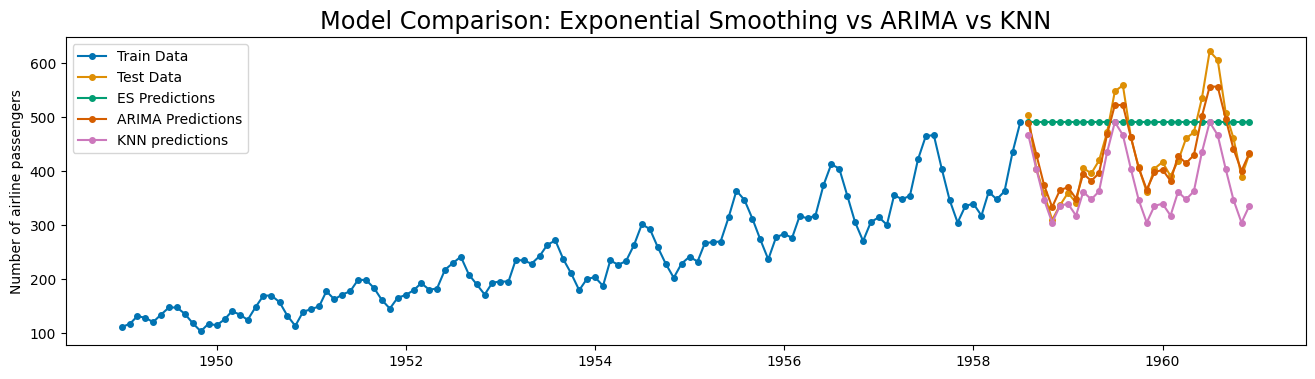

In [ ]:
plot_series(airline_train, airline_test, airline_pred_es, airline_pred_arima, airline_pred_knn, labels=["Train Data", "Test Data", "ES Predictions", "ARIMA Predictions", "KNN predictions"], title="Model Comparison: Exponential Smoothing vs ARIMA vs KNN")

####  Model Evaluation and Error Metrics

To evaluate the performance of the model, we can compute error metrics like MAPE (Mean Absolute Percentage Error) and RMSE (Root Mean Squared Error).

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanSquaredError

In [ ]:
mape = MeanAbsolutePercentageError()
rmse = MeanSquaredError(square_root=True)

for y_pred, name in zip([airline_pred_es, airline_pred_arima, airline_pred_knn], ['ES', 'ARIMA', 'KNN']):
    print(f"Mean Absolute Percentage Error for {name}: {mape(airline_test, y_pred)}")

for y_pred, name in zip([airline_pred_es, airline_pred_arima, airline_pred_knn], ['ES', 'ARIMA', 'KNN']):
    print(f"Root Mean Squared Error for {name}: {rmse(airline_test, y_pred)}")

Mean Absolute Percentage Error for ES: 0.20182545156232284
Mean Absolute Percentage Error for ARIMA: 0.04229420585332853
Mean Absolute Percentage Error for KNN: 0.1403790054823889
Root Mean Squared Error for ES: 93.06864683063684
Root Mean Squared Error for ARIMA: 25.114107957096465
Root Mean Squared Error for KNN: 75.23388818235092


#### Prediction intervals

And for a better understanding of the probabilistic nature of the forecasts we can use prediction intervals. With that we can account for uncertainty in the forecast and the random variation of the data.

In [ ]:
y = load_airline()

y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

fh = np.arange(1, len(y_test.index))

In [ ]:
best_forecaster = ARIMA(order=(2, 1, 1), seasonal_order=(1, 1, 0, 12))
best_forecaster.fit(y_train, fh=fh)

ARIMA(order=(2, 1, 1), seasonal_order=(1, 1, 0, 12))

In [ ]:
coverage = 0.9
y_pred_ints = best_forecaster.predict_interval(coverage=coverage)
y_pred_ints

Number of airline passengers            
                                 0.9            
                               lower       upper
1958-08                   474.565906  505.700105
1958-09                   410.251551  451.026065
1958-10                   348.698722  399.451024
1958-11                   304.823301  362.763831
1958-12                   332.790461  397.727547
1959-01                   334.913288  405.828452
1959-02                   311.267200  387.880206
1959-03                   354.456501  436.267087
1959-04                   338.993927  425.750471
1959-05                   350.884103  442.285514
1959-06                   420.236248  516.077092
1959-07                   472.650968  572.723306
1959-08                   465.159996  579.739288
1959-09                   399.908887  525.580730
1959-10                   337.782868  474.964881
1959-11                   292.579686  439.656088
1959-12                   319.396956  476.150402
1960-01                   320.173719  485.808157
1960-02                   295.188552  469.384159
1960-03                   336.950015  519.228954
1960-04                   320.186908  510.249637
1960-05                   331.031615  528.546184
1960-06                   399.315787  604.025876
1960-07                   450.823880  662.476415
1960-08                   443.212613  669.951102
1960-09                   377.420143  616.896183
1960-10                   314.690961  567.338214
1960-11                   268.727526  533.289079

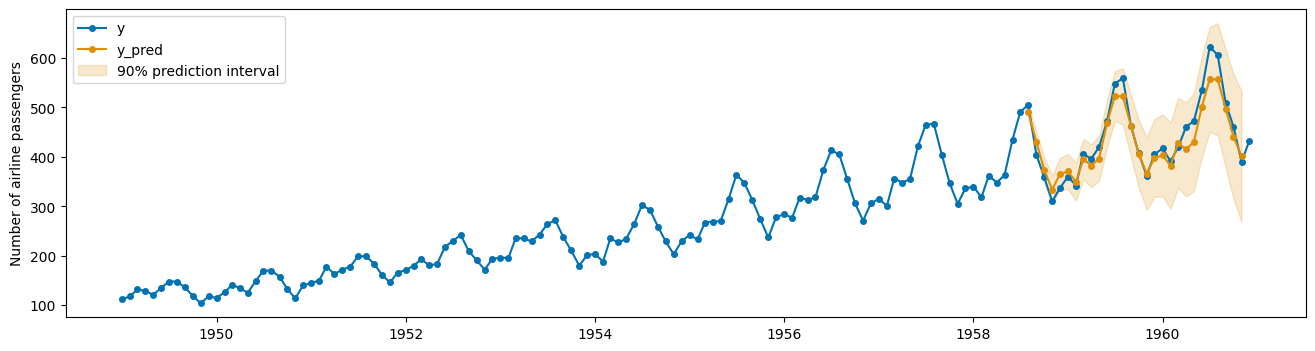

In [ ]:
y_pred = best_forecaster.predict()

fig, ax = plot_series(
    y, y_pred, labels=["y", "y_pred"], pred_interval=y_pred_ints
)

## Next Steps

What we showed today is of course not all the steps needed to achieve a best possible forecast for this single time series. There could be still multiple things that a practioner could try to improve the final forecast.

One could still:
- try different data transformations (detrending, deseasonalizing, scaling etc.)
- try expanding the hyperparameter space or tuning different hyperparameters of the already used models
- try different models (PolynomialTrendForecaster, STLForecaster, ThetaForecaster, TBATS, Prophet, RandomForest, XGBoost and many many more)



